# Class Activation Map 만들기

1. CAM 용 classification 모델 준비하기
2. CAM
3. Grad-CAM
4. Detection with CAM

## 데이터셋 준비하기
* `Localization` + `Classification` -> `stanford_dogs`

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    shuffle_files=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


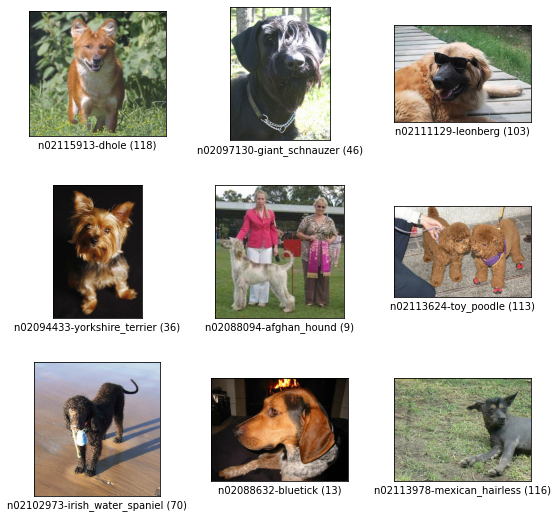

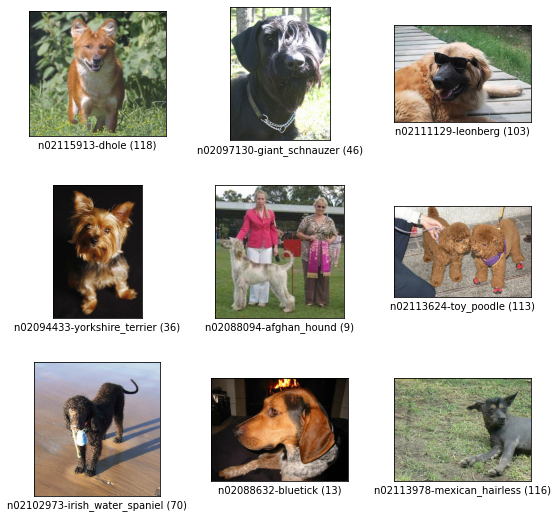

In [4]:
tfds.show_examples(ds_train, ds_info)

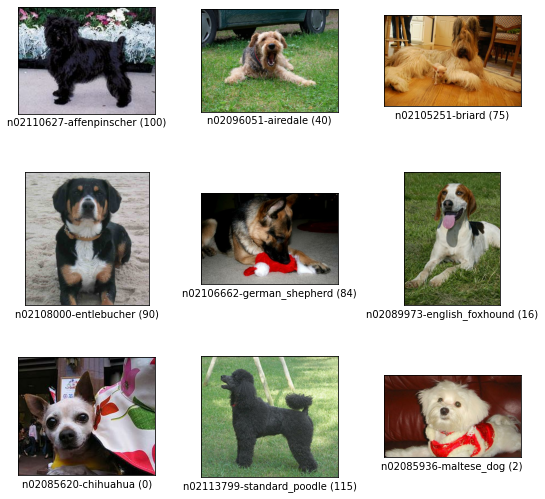

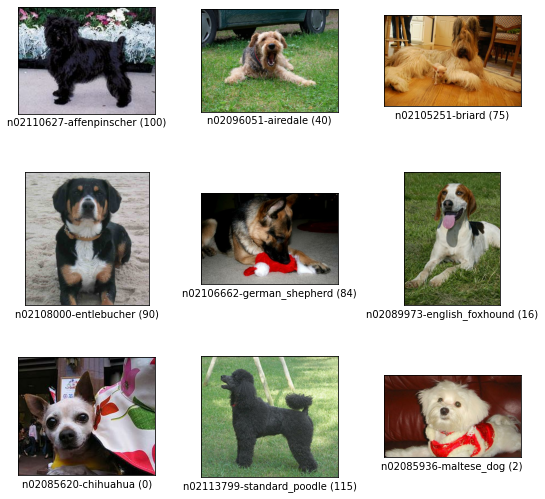

In [5]:
tfds.show_examples(ds_test, ds_info)

## Localization
### Bounding Box
* `xywh`
* `minmax`
* `LRTB`, `QUAD`, ...

In [6]:
# 메타데이터 -> ds_info
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## CAM을 위한 모델 만들기
`ResNet50` -> `fully connected layer` 제거 -> `GAP`, `softmax 레이어` 추가

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 모델 학습하기
* `normalize_and_resize_img()`
* `apply_normlize_on_dataset()`: Batch 구성

In [9]:
def normalize_and_resize_img(input):
    # normalizes images 'uint8' -> `float32`
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/15
750/750 [==============================] - 385s 461ms/step - loss: 3.2385 - accuracy: 0.2754 - val_loss: 3.3651 - val_accuracy: 0.2115
Epoch 2/15
750/750 [==============================] - 332s 442ms/step - loss: 0.9491 - accuracy: 0.7355 - val_loss: 1.0898 - val_accuracy: 0.6837
Epoch 3/15
750/750 [==============================] - 328s 437ms/step - loss: 0.3569 - accuracy: 0.9088 - val_loss: 1.0206 - val_accuracy: 0.6980
Epoch 4/15
750/750 [==============================] - 328s 438ms/step - loss: 0.0927 - accuracy: 0.9905 - val_loss: 0.9267 - val_accuracy: 0.7299
Epoch 5/15
750/750 [==============================] - 328s 438ms/step - loss: 0.0359 - accuracy: 0.9973 - val_loss: 0.9075 - val_accuracy: 0.7373
Epoch 6/15
750/750 [==============================] - 328s 438ms/step - loss: 0.0179 - accuracy: 0.9999 - val_loss: 0.8812 - val_accuracy: 0.7482
Epoch 7/15
750/750 [==============================] - 328s 438ms/step - loss: 0.0193 - accuracy: 0.9997 - val_loss: 0.9370 -

In [13]:
import os

cam_model_path = os.getenv("HOME") + '/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("Save complete!")

Save complete!


In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

71


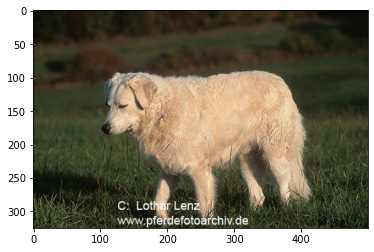

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### 이전에 학습한 모델 불러오기

In [16]:
import os
cam_model_path = os.getenv("HOME") + '/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

* CAM을 생성하기 위해서는 (1) 특성맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, (3) 원하는 클래스의 출력값이 필요함.
* 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야함

In [23]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # model.layer[-3].output 에서 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]  # 마지막 모델의 weight activation 을 가져옵니다
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W*f 를 통해 class 별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]
    
    cam_image /= np.max(cam_image)   # activation score를 normalize 합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))   # 원래 이미지 크기로 resize
    return cam_image

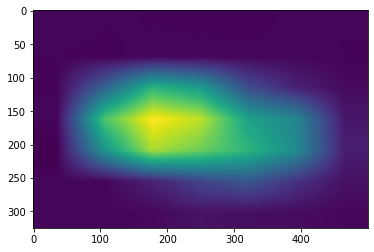

In [24]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

* 그려진 CAM 이미지를 원본 이미지와 합쳐 확인한다

In [26]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

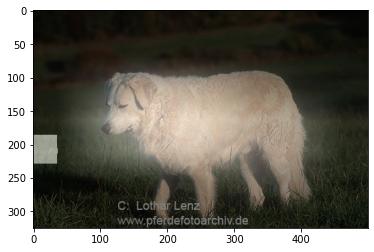

In [28]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()